In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import src.basic_function_cap as bfc
import src.piano_key_notes as pkn
import ipywidgets as widgets
from ipywidgets import interact

# Crop video

In [2]:
cap = cv2.VideoCapture('mp4/scarborough_fair.mp4')

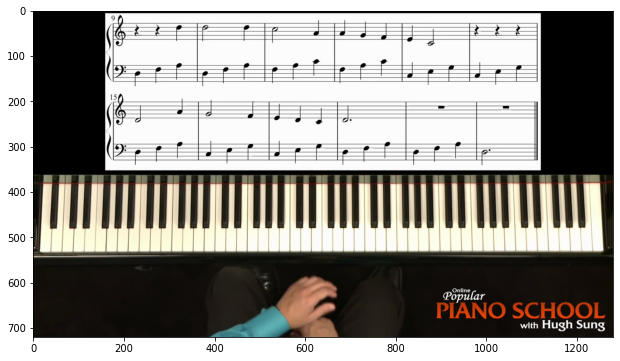

In [3]:
bfc.show_frame(cap, 814)
_, frame = bfc.get_frame(cap, 814)

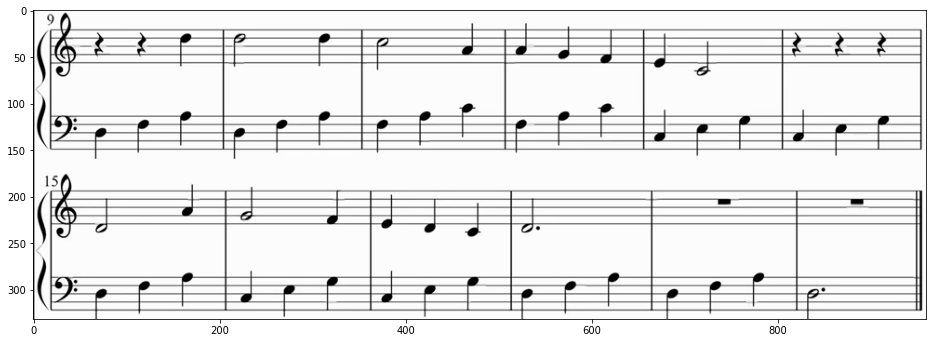

In [4]:
cropped_sheets = bfc.crop_frame(frame, 8, 158, 340-8, 960, show=True)

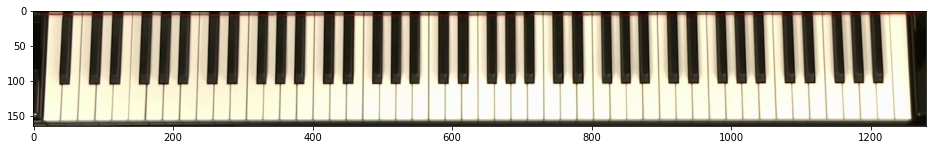

In [5]:
cropped = bfc.crop_frame(frame, 375, 0, 540-375, frame.shape[1], show=True)

# Get notes

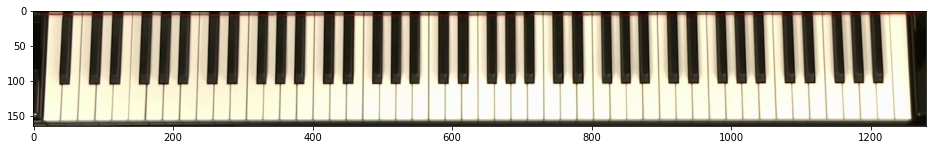

In [6]:
cap = cv2.VideoCapture('mp4/scarborough_fair.mp4')
image = bfc.get_frame(cap, 814)[1]
image = bfc.crop_frame(image, 375, 0, 540-375, image.shape[1], show=True)

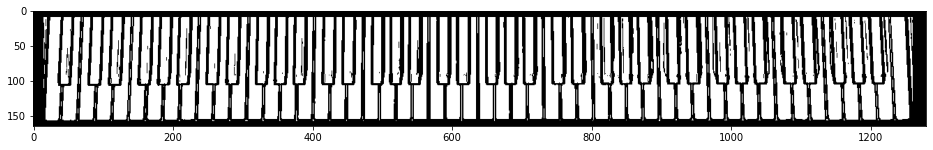

Number of connected components: 88


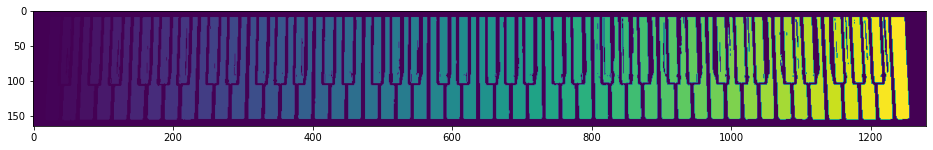

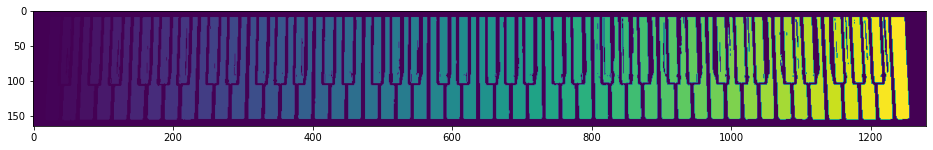

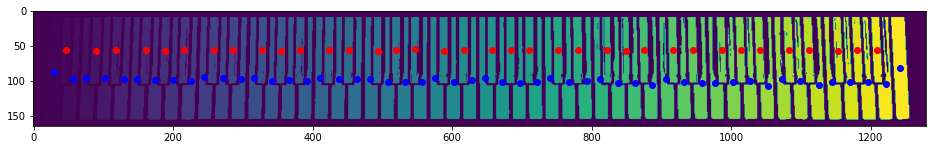

  0%|          | 0/36 [00:00<?, ?it/s]

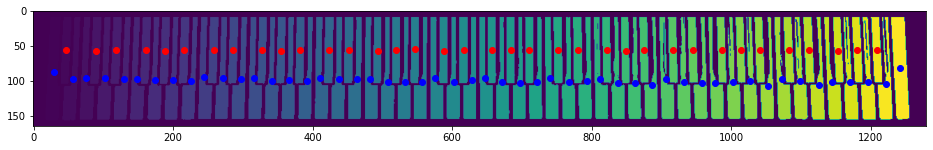

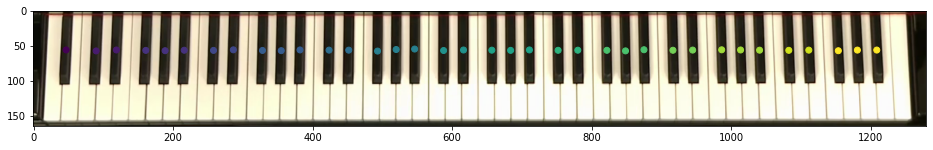

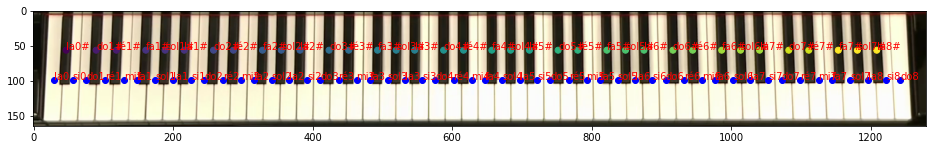

In [7]:
pipe = pkn.pipeline(image, with_hull=True, threshold = 4000, kx=15, crop=[10,7,15,19], min_area=300, max_width=200, show=True)
labels, black_keys, white_keys, n_labels, stats, centroids, group, notes, sobel = pipe

# Hightlight notes from sheet

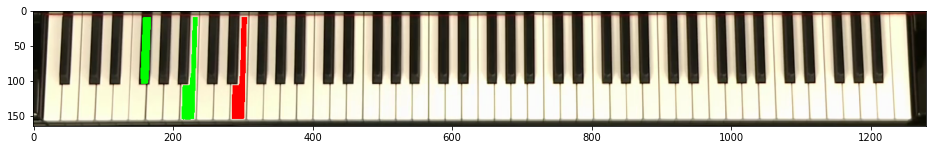

In [8]:
g = [0,255,0]
b = [0,0,255]
r = [255,0,0]
_ = pkn.highlight_keys(image=image, labels=labels, keys = [10,15,20], color = [g,g,r], show=True)

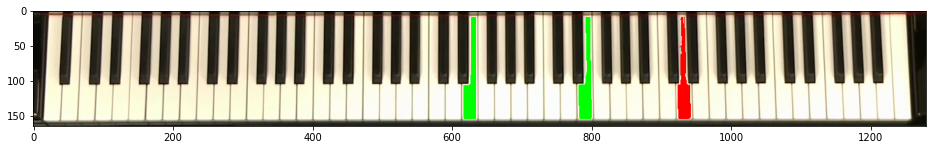

In [9]:
_ = pkn.highlight_notes(image=image, labels=labels, notes = ["mi4", "mi5", "ré6"], dict_notes = notes, color = [g,g,r], show=True)

# Get difference

In [10]:
cap = cv2.VideoCapture('mp4/scarborough_fair.mp4')

def show_frame(frame_number, shift):
    _, mask = bfc.get_frame(cap, 219)
    _, frame = bfc.get_frame(cap, 219+frame_number)
    mask = bfc.crop_frame(mask, 330, 0, 540-330, frame.shape[1])
    frame = bfc.crop_frame(frame, 330, 0, 540-330, frame.shape[1])
    plt.figure(figsize=(16,16))
    plt.imshow(frame)
    plt.show()
    plt.figure(figsize=(16,16))
    plt.imshow(frame - mask + shift)
    plt.show()

interact(show_frame,
        frame_number=widgets.IntSlider(min=0, max=32*32-10, step=1, value=100),
        shift=widgets.IntSlider(min=0, max=30, step=1, value=0))

interactive(children=(IntSlider(value=100, description='frame_number', max=1014), IntSlider(value=0, descripti…

<function __main__.show_frame(frame_number, shift)>

In [11]:
def show_frame(key_number):
    pkn.highlight_key_from_image(image=image, labels=labels, key_number = key_number, show=True)

interact(show_frame,
        key_number=widgets.IntSlider(min=0, max=n_labels, step=1, value=0))

interactive(children=(IntSlider(value=0, description='key_number', max=89), Output()), _dom_classes=('widget-i…

<function __main__.show_frame(key_number)>

# Read partition

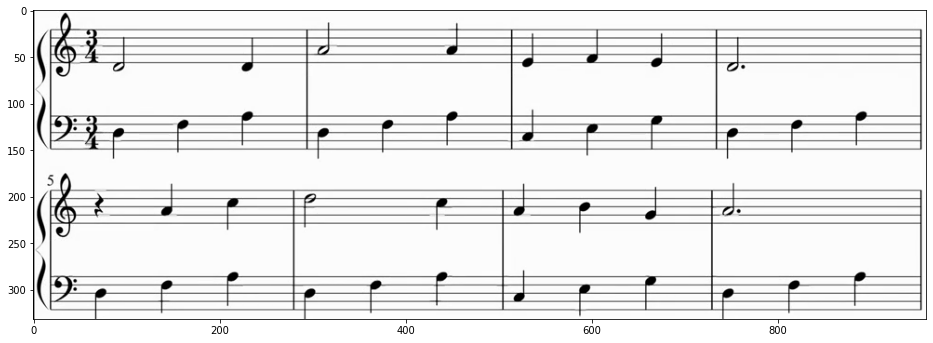

In [326]:
cap = cv2.VideoCapture('mp4/scarborough_fair.mp4')
_, frame = bfc.get_frame(cap, 10)
img = bfc.crop_frame(frame, 8, 158, 340-8, 960, show=True)

## Black notes

In [ ]:
def dilate_img(img, kernel_size_x=3, kernel_size_y=3, iterations=1, show = False):
    kernel = np.ones((kernel_size_x, kernel_size_y), np.uint8)
    dilation = cv2.dilate(img,kernel,iterations = iterations)
    if show:
        plt.figure(figsize=(16,6))
        plt.imshow(dilation)
        plt.show()
    return dilation

def erode_img(img, kernel_size_x=3, kernel_size_y=3, iterations=1, show = False):
    kernel = np.ones((kernel_size_x, kernel_size_y), np.uint8)
    erosion = cv2.erode(img,kernel,iterations = iterations)
    if show:
        plt.figure(figsize=(16,6))
        plt.imshow(erosion)
        plt.show()
    return erosion

In [172]:
def get_black_notes(img, show = False):

    dilated = dilate_img(img, 8, 6, show = False)
    eroded = erode_img(dilated, 8, 6, show = False)

    gray = np.float32(cv2.cvtColor(eroded,cv2.COLOR_BGR2GRAY))

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = 5)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = 5)
    sobel = np.sqrt(sobelx**2 + sobely**2)
    sobel = (sobel / sobel.max()*255).astype(np.uint8)

    black_white_threshold = 50
    sobel[sobel <= black_white_threshold] = 0
    sobel[sobel > black_white_threshold] = 255

    circles = cv2.HoughCircles(sobel, cv2.HOUGH_GRADIENT, dp = 1, minDist = 15, param1 = 1, param2 = 6,
                                minRadius = 5,
                                maxRadius = 7
                            )
    circles = np.uint16(np.around(circles))

    img_circles = img.copy()
    for i in circles[0,:]:
        cv2.circle(img_circles,(i[0],i[1]),i[2],(0,255,0),2)

    if show:
        plt.figure(figsize=(16,6))
        plt.imshow(img_circles)
        plt.show()

    return circles


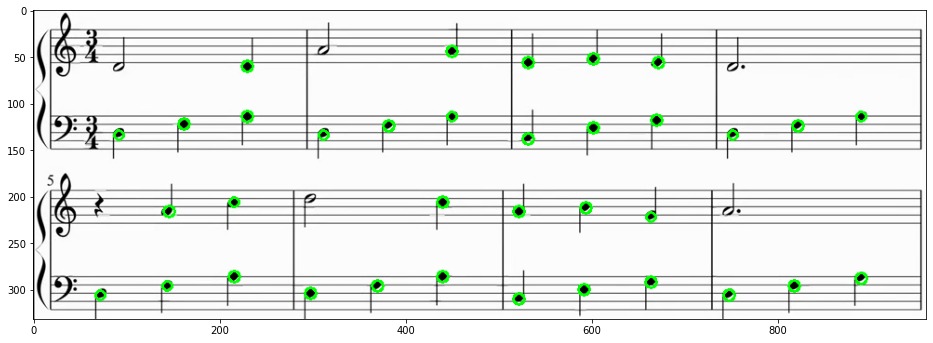

In [322]:
_, frame = bfc.get_frame(cap, 10)
img = bfc.crop_frame(frame, 8, 158, 340-8, 960, show=False)
_ = get_black_notes(img, show=True)

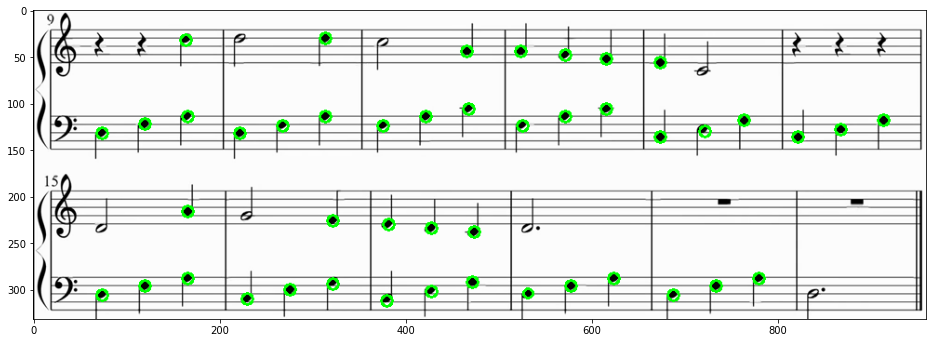

In [331]:
_, frame = bfc.get_frame(cap, 780)
img = bfc.crop_frame(frame, 8, 158, 340-8, 960, show=False)
_ = get_black_notes(img, show=True)

## White notes

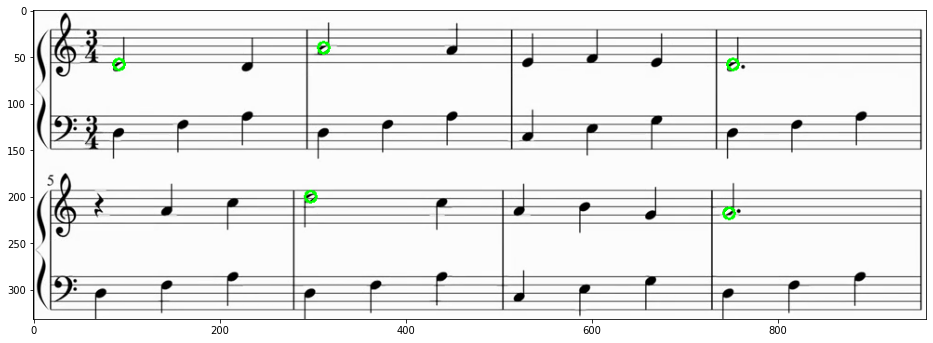

In [332]:
def get_white_notes(img, dp=1, minDist=20, param1=1000, param2=7, minRadius=6, maxRadius=7, show = False):

    gray = np.uint8(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY))
    inverse = 255 - gray

    circles = cv2.HoughCircles(inverse, cv2.HOUGH_GRADIENT, dp = dp, minDist = minDist, param1 = param1, param2 = param2,
                                minRadius = minRadius,
                                maxRadius = maxRadius
                            )
    circles = np.uint16(np.around(circles))
    new_circles = [] 

    img_circles = img.copy()
    for i in range(len(circles[0,:])):
        if circles[0,i][0] > 70: # remove circles too close to the left
            if max(img[circles[0,i][1]+x, circles[0,i][0]+j, 0] for x in range(-1,2) for j in range(-1,2)) > 200: # if the center of the circle is not black
                cv2.circle(img_circles,(circles[0,i][0],circles[0,i][1]),circles[0,i][2],(0,255,0),2)
                new_circles.append(circles[0,i])

    if show:
        plt.figure(figsize=(16,6))
        plt.imshow(img_circles)
        plt.show()

    return np.array([new_circles])

cap = cv2.VideoCapture('mp4/scarborough_fair.mp4')
_, frame = bfc.get_frame(cap, 10)
img = bfc.crop_frame(frame, 8, 158, 340-8, 960, show=False)
_ = get_white_notes(img, dp=1, minDist=20, param1=1000, param2=7, minRadius=6, maxRadius=7, show=True)

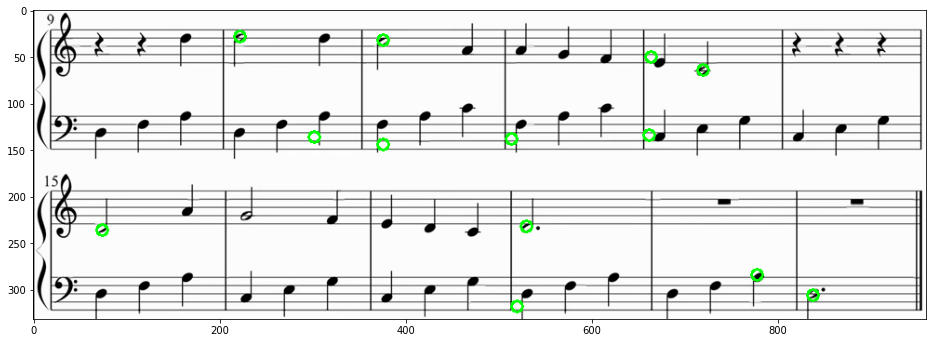

In [333]:
cap = cv2.VideoCapture('mp4/scarborough_fair.mp4')
_, frame = bfc.get_frame(cap, 677)
img = bfc.crop_frame(frame, 8, 158, 340-8, 960, show=False)
_ = get_white_notes(img, dp=1, minDist=20, param1=1000, param2=6, minRadius=6, maxRadius=7,show=True)

## Combine white and black notes

In [334]:
def min_distance(center, circles):
    if len(circles) == 0:
        return 1000000
    return min(np.sqrt((center[0].astype(int) - circles[:,0].astype(int))**2 + (center[1].astype(int) - circles[:,1].astype(int))**2))

# we want the white_circle to be far enough from all the black circles
def all_notes_circles(img, black_circles, white_circles, min_dist=20, show=False):
    new_white_circles = []
    for i in range(len(white_circles[0])):
        white_circle = white_circles[0,i]
        if min_distance(white_circle, black_circles[0]) > min_dist and min_distance(white_circle, white_circles[0,i+1:]) > min_dist:
            new_white_circles.append(white_circle)
    new_white_circles = np.array([new_white_circles])
    if show:
        img_circles = img.copy()
        for i in new_white_circles[0,:]:
            cv2.circle(img_circles,(i[0],i[1]),i[2],(0,0,255),2)
        for i in black_circles[0,:]:
            cv2.circle(img_circles,(i[0],i[1]),i[2],(0,255,0),2)
        plt.figure(figsize=(16,6))
        plt.imshow(img_circles)
        plt.show()
    all_circles = np.concatenate((black_circles, new_white_circles), axis=1)
    return all_circles


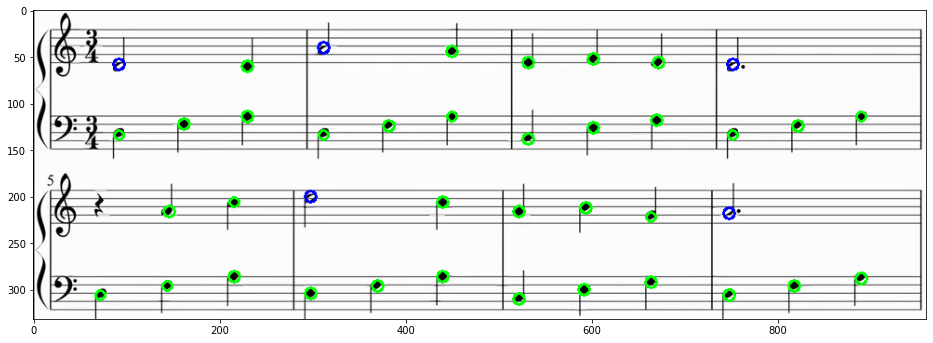

In [319]:
cap = cv2.VideoCapture('mp4/scarborough_fair.mp4')
_, frame = bfc.get_frame(cap, 10)
img = bfc.crop_frame(frame, 8, 158, 340-8, 960, show=False)
black_circles = get_black_notes(img)
white_circles = get_white_notes(img, dp=1, minDist=20, param1=1000, param2=7, minRadius=6, maxRadius=7)
all_circles = all_notes_circles(img, black_circles, white_circles, min_dist=10, show=True)

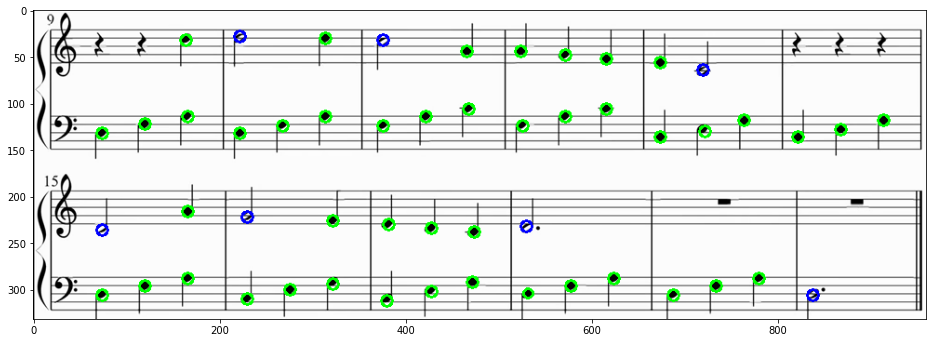

In [335]:
_, frame = bfc.get_frame(cap, 781)
img = bfc.crop_frame(frame, 8, 158, 340-8, 960, show=False)
black_circles = get_black_notes(img)

_, frame = bfc.get_frame(cap, 677)
img = bfc.crop_frame(frame, 8, 158, 340-8, 960, show=False)
white_circles1 = get_white_notes(img, dp=1, minDist=20, param1=1000, param2=6, minRadius=6, maxRadius=7)
white_circles2 = get_white_notes(img, dp=1, minDist=20, param1=1000, param2=7, minRadius=6, maxRadius=7)
white_circles = np.concatenate((white_circles1, white_circles2), axis=1)

all_circles = all_notes_circles(img, black_circles, white_circles, min_dist=30, show=True)